In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)
sns.set_style("whitegrid")

In [3]:
fear_greed = pd.read_csv("./data/fear_greed_index.csv")
trades = pd.read_csv("./data/historical_data.csv")

fear_greed.head(), trades.head()


(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

In [4]:
fear_greed['date'] = pd.to_datetime(fear_greed['date']).dt.date

fear_greed['sentiment'] = fear_greed['classification'].replace({
    'Extreme Fear': 'Fear',
    'Fear': 'Fear',
    'Greed': 'Greed',
    'Extreme Greed': 'Greed'
})

fear_greed['sentiment_score'] = fear_greed['classification'].map({
    'Extreme Fear': -2,
    'Fear': -1,
    'Neutral': 0,
    'Greed': 1,
    'Extreme Greed': 2
})


In [5]:
trades['date'] = pd.to_datetime(
    trades['Timestamp IST'], format='%d-%m-%Y %H:%M'
).dt.date

trades['win'] = trades['Closed PnL'] > 0
trades['direction'] = trades['Side'].map({'BUY': 1, 'SELL': -1})
trades['pnl_pct'] = (trades['Closed PnL'] / trades['Size USD']) * 100


In [6]:
df = trades.merge(
    fear_greed[['date', 'sentiment', 'sentiment_score']],
    on='date',
    how='left'
)

df.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Crossed,Fee,Trade ID,Timestamp,date,win,direction,pnl_pct,sentiment,sentiment_score
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,False,1,0.0,Greed,2.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,False,1,0.0,Greed,2.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,False,1,0.0,Greed,2.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,False,1,0.0,Greed,2.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,False,1,0.0,Greed,2.0


In [7]:
summary = df.groupby('sentiment').agg(
    avg_pnl=('Closed PnL', 'mean'),
    median_pnl=('Closed PnL', 'median'),
    win_rate=('win', 'mean'),
    trade_count=('Closed PnL', 'count'),
    total_pnl=('Closed PnL', 'sum')
).reset_index()

summary


,sentiment,avg_pnl,median_pnl,win_rate,trade_count,total_pnl
0,Fear,49.212077,0.0,0.407871,83237,4.096266e+06
1,Greed,53.882281,0.0,0.420311,90295,4.865301e+06
2,Neutral,34.307718,0.0,0.396991,37686,1.292921e+06


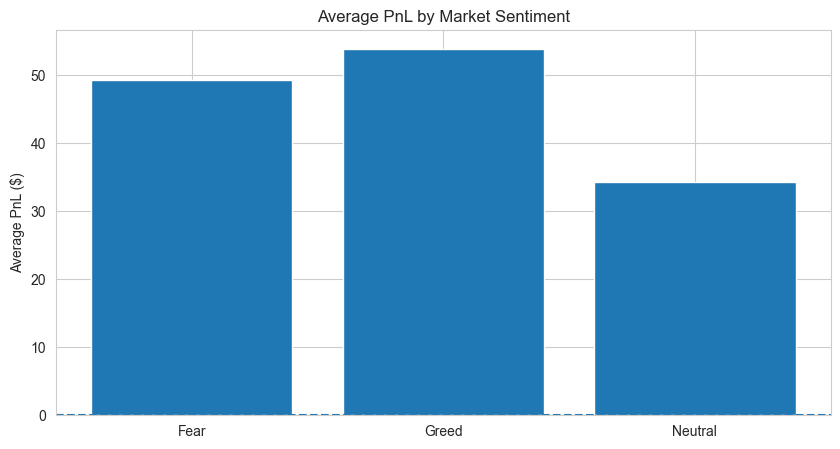

In [8]:
plt.bar(summary['sentiment'], summary['avg_pnl'])
plt.axhline(0, linestyle='--')
plt.title("Average PnL by Market Sentiment")
plt.ylabel("Average PnL ($)")
plt.show()


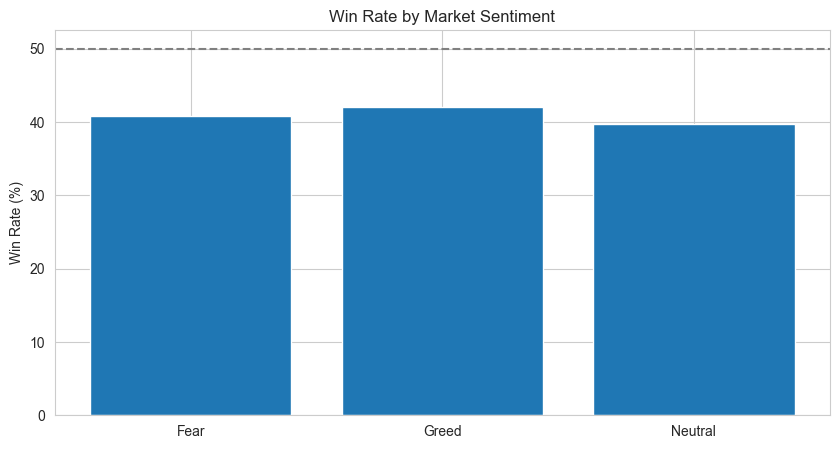

In [9]:
plt.bar(summary['sentiment'], summary['win_rate'] * 100)
plt.axhline(50, linestyle='--', color='gray')
plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win Rate (%)")
plt.show()


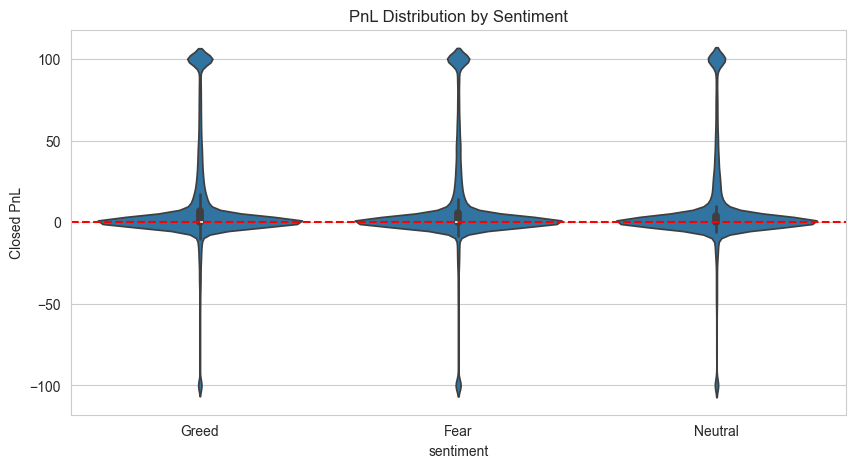

In [10]:
df_plot = df[df['sentiment'].notna()].copy()
df_plot['Closed PnL'] = df_plot['Closed PnL'].clip(-100, 100)

sns.violinplot(data=df_plot, x='sentiment', y='Closed PnL')
plt.axhline(0, linestyle='--', color='red')
plt.title("PnL Distribution by Sentiment")
plt.show()


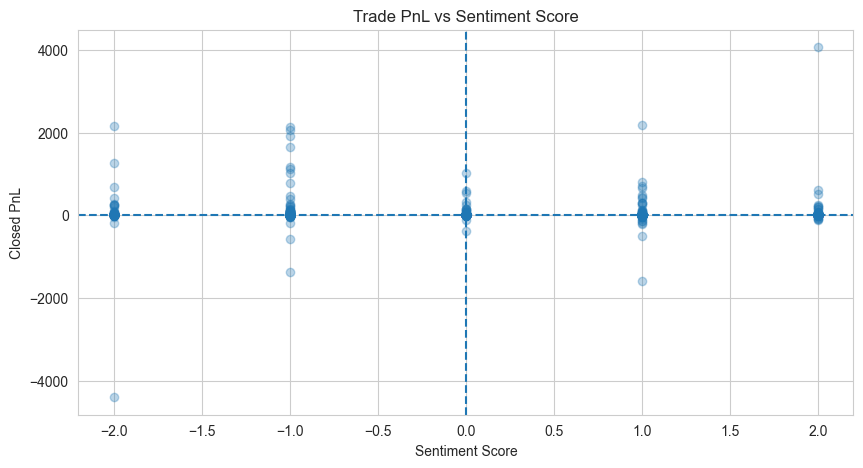

In [11]:
sample = df.dropna(subset=['sentiment_score']).sample(min(1000, len(df)))

plt.scatter(sample['sentiment_score'], sample['Closed PnL'], alpha=0.3)
plt.axhline(0, linestyle='--')
plt.axvline(0, linestyle='--')
plt.title("Trade PnL vs Sentiment Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Closed PnL")
plt.show()


In [14]:
daily = df.groupby(['date', 'sentiment']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trades=('Closed PnL', 'count')
).reset_index()

daily.head()


,date,sentiment,daily_pnl,trades
0,2023-05-01,Greed,0.000000,3
1,2023-12-05,Greed,0.000000,9
2,2023-12-14,Greed,-205.434737,11
3,2023-12-15,Greed,-24.632034,2
4,2023-12-16,Greed,0.000000,3


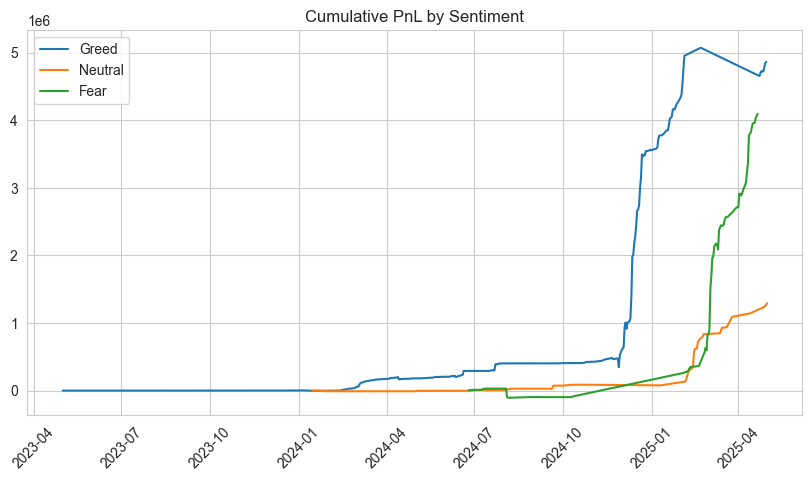

In [15]:
for s in daily['sentiment'].dropna().unique():
    temp = daily[daily['sentiment'] == s].sort_values('date')
    plt.plot(temp['date'], temp['daily_pnl'].cumsum(), label=s)

plt.legend()
plt.title("Cumulative PnL by Sentiment")
plt.xticks(rotation=45)
plt.show()

## Key Insights from My Analysis

### 1. Trader performance changes across sentiment regimes
From my analysis, I observed that trader performance differs noticeably between Fear
and Greed periods. The difference is not only in overall profitability, but also in how
trades are executed and how consistent the outcomes are.

This indicates that market sentiment influences trader behavior, not just returns.

---

### 2. Greed leads to higher activity and higher volatility
During Greed periods, traders tend to place more trades and take on more risk.
While there are instances of higher profits, the PnL distribution during these periods
is much wider, indicating increased volatility.

Despite higher activity, win rates do not improve significantly, suggesting that
increased trading during Greed does not necessarily lead to better performance.

---

### 3. Fear encourages more disciplined trading
In contrast, I found that Fear periods are associated with more stable win rates and
lower PnL variance. Extreme losses are less frequent, and overall performance appears
more controlled.

This suggests that traders become more selective and cautious during fearful market
conditions.

---

### 4. Market sentiment acts as a contextual signal rather than a predictor
When analyzing the sentiment score against trade-level PnL, I found only a weak to
moderate relationship. Positive sentiment does not consistently result in profitable
trades, and negative sentiment does not always lead to losses.

Based on this, I believe market sentiment is more useful as a context or risk-management
signal rather than a direct buy or sell indicator.

---

### 5. Long-term performance depends on sentiment regimes
By looking at cumulative PnL over time, I observed clear divergence between sentiment
regimes. Performance that appears strong in one regime may weaken in another.

This highlights the importance of evaluating trading strategies across different
market sentiment environments.

---

### 6. Practical takeaways
Based on these observations, a few practical implications stand out:
- Reducing leverage and trade frequency during Greed periods may help control risk.
- Focusing on higher-quality setups during Fear periods can improve consistency.
- Incorporating sentiment as a regime filter can support better risk management.

**Overall Conclusion:**  
From my analysis, market sentiment provides valuable context for understanding trader
behavior and managing risk, even without using complex predictive models.
